# GLEAM: Model Configuration & Usage Guide

Below is the breakdown of the pipeline configuration:

### 1. What is the Input?
The model effectively utilizes **three distinct data matrices** to handle the different requirements of integration vs. prediction:

* **`adata_rna`**: Single-cell Gene Expression data (Cell $\times$ Gene). Used for both integration and as a prediction target.
* **`adata_atac`**: Single-cell Chromatin Accessibility data (Cell $\times$ **Peak**). This is the **prediction target** for the GNN. The model constructs graph nodes representing these peaks.
* **`adata_atac_gas`**: ATAC Gene Activity Scores (Cell $\times$ **Gene**). This is required **only for the integration step**. It projects ATAC data into the same feature space as RNA (genes) to calculate the initial cell-to-cell similarity graph.

**Note 1:** You must generate the Gene Activity Scores (GAS) from your ATAC peaks (e.g., using Seurat or Scanpy to sum peaks within gene bodies) before running the pipeline. 
 
**Note 2:** We used RNA-seq and ATAC-seq as examples, but this tool can be utilized on other modalities.

### 2. How are the Parameters Set?
Key hyperparameters are defined in the `Trainer` and `refine_graph` steps:
* **`input_channels`**: The dimension of the initial PCA projection (default: `50`).
* **`hidden_channels`**: The dimension of the GNN latent space (default: `64`). Larger numbers capture more complex patterns but increase memory usage.
* **`epochs`**: Number of training iterations (default: `100` for testing the code, `600+` for real data).
* **`ZERO1` / `ZERO2`**: Zero-inflation flags (`1` = True, `0` = False). Set to `1` for sparse single-cell data (scRNA/scATAC) to handle dropouts.

### 3. What is the Output?
The pipeline generates **CSV files** in the defined output directory (e.g., `output_test/`).
* **`*_pred-weight.csv`**: The predicted gene expression or peak accessibility values.
* **`*_pred-exist.csv`**: The probability of a non-dropout event (probability that the edge exists).
* **`saved_embeddings`**: The model cache contains latent representations for cells (`model.cache['saved_embeddings']['cell']`) which can be extracted for downstream analysis.

### 4. What to Plot?
* **Integration Accuracy**: UMAP on whether the embeddings from the two modalities are on the same space.
* **Reconstruction Accuracy**: Heatmap comparing the `pred` values against the held-out ground truth (`obs` data) for specific marker genes.

> **Tip:** Although not required in the README, we recommend installing matplotlib and seaborn via `pip install matplotlib seaborn` to visualize results.

In [10]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from gleam.model import Model, Trainer, predict
from gleam.preprocess import load_from_AnnData, pred_from_AnnData
from gleam.emb import refine_graph_and_prepare_data_scanpy
import scanorama
# Set seeds
np.random.seed(42)
torch.manual_seed(42)


In [11]:
# --- 1. Load Data ---
print("Loading data...")
# Assuming standard filenames based on your description
adata_rna = sc.read_h5ad("/fh/working/sun_w/sshen/runGLEAM/rna.h5ad")
adata_atac = sc.read_h5ad("/fh/working/sun_w/sshen/runGLEAM/atac.h5ad")
adata_gas = sc.read_h5ad("/fh/working/sun_w/sshen/runGLEAM/atac_gas.h5ad")

# Ensure ATAC and GAS have the same cell ordering before splitting
# (This assumes atac and atac_gas contain the same cells in the same order initially)
assert adata_atac.shape[0] == adata_gas.shape[0], "ATAC peaks and GAS matrices must have the same number of cells."
adata_atac.obs_names = adata_gas.obs_names 

# --- 2. Random Split (2/3 Train, 1/3 Test) ---
print("Splitting data into Training (2/3) and Testing (1/3)...")

def get_split_indices(n_cells, train_fraction=2/3, seed=None):
    # Set the seed strictly for this call
    np.random.seed(seed)
    indices = np.random.permutation(n_cells)
    split_point = int(n_cells * train_fraction)
    return indices[:split_point], indices[split_point:]

n_total = adata_rna.shape[0]

# A. Split RNA (Use Seed 42)
print("   > Splitting RNA...")
rna_train_idx, rna_test_idx = get_split_indices(n_total, seed=42)

rna_train = adata_rna[rna_train_idx].copy()
rna_test = adata_rna[rna_test_idx].copy()

# B. Split ATAC (Use DIFFERENT Seed 99)
# This ensures we pick a *different* random set of cells for ATAC
print("   > Splitting ATAC...")
atac_train_idx, atac_test_idx = get_split_indices(n_total, seed=99)

# Slice ATAC Peaks
atac_train = adata_atac[atac_train_idx].copy()
atac_test = adata_atac[atac_test_idx].copy()

# Slice ATAC Gene Scores (Must match ATAC train indices to stay synced with peaks)
gas_train = adata_gas[atac_train_idx].copy()
gas_test = adata_gas[atac_test_idx].copy()

train_overlap = len(set(rna_train.obs_names) & set(atac_train.obs_names))
print(f"\n--- Split Summary ---")
print(f"Total Cells: {n_total}")
print(f"RNA Train Size: {rna_train.n_obs}")
print(f"ATAC Train Size: {atac_train.n_obs}")
print(f"Overlapping Cells (Paired): {train_overlap}")
print(f"Expected Overlap: ~{(2/3 * 2/3 * n_total):.0f} (approx 44% of total)")

# --- 3. Feature Alignment (Intersection of Genes) ---
# Since cells don't match 1:1, we MUST align the features (Genes)
print("Aligning features between RNA and ATAC Gene Activity Scores...")

# Find common genes between RNA and GAS
common_genes = np.intersect1d(rna_train.var_names, gas_train.var_names)

print(f"Found {len(common_genes)} common genes for integration.")

# Subset RNA and GAS to common genes
rna_train = rna_train[:, common_genes].copy()
gas_train = gas_train[:, common_genes].copy()

# Mark the modality in the objects (helpful for plotting later)
rna_train.obs['modality'] = 'RNA'
gas_train.obs['modality'] = 'ATAC' 

# Final subset to Highly Variable Genes (HVGs) found in RNA
# (This focuses the integration on the most informative biological signals)
hvg_genes = rna_train.var_names
rna_train = rna_train[:, hvg_genes].copy()
gas_train = gas_train[:, hvg_genes].copy()

print(f"Final training dimensions:")
print(f"RNA: {rna_train.shape}")
print(f"ATAC (GAS): {gas_train.shape}")

# --- 5. Inputs for the Model ---
# The model likely accepts 'adata_rna' and 'adata_atac'.
# We pass 'gas_train' as the second argument because it shares the feature space (Genes)
# which is required for the encoders to align the manifolds.
adata_rna_final = rna_train
adata_atac_final = gas_train 

Loading data...
Splitting data into Training (2/3) and Testing (1/3)...
   > Splitting RNA...
   > Splitting ATAC...

--- Split Summary ---
Total Cells: 16419
RNA Train Size: 10946
ATAC Train Size: 10946
Overlapping Cells (Paired): 7294
Expected Overlap: ~7297 (approx 44% of total)
Aligning features between RNA and ATAC Gene Activity Scores...
Found 756 common genes for integration.
Final training dimensions:
RNA: (10946, 756)
ATAC (GAS): (10946, 756)


In [12]:
# ==========================================
# 1. Integration
# ==========================================

def integrate_rna_atac_scanorama(adata_rna, adata_atac_gas):
    """
    Integrates RNA and ATAC (Gene Scores) using Scanorama.
    
    Scanorama is efficient for Mosaic data because it automatically detects 
    overlapping cell states (anchors) without requiring 1-to-1 matching.
    """
    print(f"Integrating {adata_rna.n_obs} RNA and {adata_atac_gas.n_obs} ATAC cells using Scanorama...")

    # 1. Prepare Inputs
    # Scanorama expects a list of AnnData objects
    # It identifies shared genes automatically, but preprocessing helps.
    
    # Create a list ensuring the order is [RNA, ATAC]
    adatas = [adata_rna.copy(), adata_atac_gas.copy()]
    
    # 2. Run Scanorama
    # integrate_scanpy modifies the objects in-place, adding 'X_scanorama' to .obsm
    # dimred=50 sets the output dimension
    print("   > Finding Mutual Nearest Neighbors and integrating...")
    scanorama.integrate_scanpy(adatas, dimred=50)

    # 3. Extract and Concatenate Embeddings
    # Scanorama computes the embedding for each dataset separately in the shared space.
    # We need to stack them to create the single "Joint Embedding" matrix the GNN expects.
    
    emb_rna = adatas[0].obsm['X_scanorama']
    emb_atac = adatas[1].obsm['X_scanorama']
    
    combined_emb = np.vstack((emb_rna, emb_atac))
    
    # 4. Create DataFrame (Index = Cell Names)
    # Ensure the order matches the concatenation (RNA first, then ATAC)
    combined_indices = list(adata_rna.obs_names) + list(adata_atac_gas.obs_names)
    
    pca_df = pd.DataFrame(
        combined_emb, 
        index=combined_indices
    )
    
    print(f"   > Scanorama Integration complete. Embedding shape: {pca_df.shape}")
    return pca_df

# ==========================================
# 2. Predict & Save (Updated for Mosaic)
# ==========================================
def predict_and_save_anndata(model, adata_rna, adata_atac, 
                             zero1, zero2, dataset_name, out_dir="output_test/"):
    """
    Runs prediction. 
    Note: 'adata_rna' here should be the Test Set RNA if you want to predict unseen data.
    """
    if not os.path.exists(out_dir): os.makedirs(out_dir)
    
    print(f"Predicting ATAC from RNA ({adata_rna.n_obs} cells)...")
    
    # We need embeddings for the specific RNA cells we are passing in.
    # If passing Training data, we can fetch from cache.
    # If passing Test data, we typically need to run 'model.encode' (inductive).
    # Assuming Transductive (Test nodes were in graph):
    
    model.cpu()
    all_emb = model.cache['saved_embeddings']['cell']
    
    # Map indices: We need to find the embedding row corresponding to each RNA cell name
    # This relies on the model.cache maintaining order or having an ID map.
    # For this snippet, we assume the graph was constructed such that 
    # the first N nodes correspond to the RNA input order. 
    # (Checking graph construction logic is recommended here).
    
    # Fallback/Assumption: We take the first n_obs embeddings
    rna_emb = all_emb[0:adata_rna.n_obs]
    
    # Run Prediction
    pred_data = pred_from_AnnData(rna_emb, adata_atac, zero2, 'conn1', 'feat1')
    pred_data['cell'].x = pred_data['cell'].x.to(torch.float32)
    pred_data = pred_data.to("cpu")
    
    with torch.no_grad():
        pred = predict(model, pred_data)
    
    # Extract results
    if zero2 == 1:
        res = pred['cell-conn1-feat1'][1].detach().numpy().flatten()
    else:
        res = pred['cell-conn1-feat1'].detach().numpy().flatten()
        
    res_matrix = res.reshape(adata_rna.n_obs, adata_atac.n_vars)
    res_df = pd.DataFrame(res_matrix, index=adata_rna.obs_names, columns=adata_atac.var_names)
    
    res_df.to_csv(f"{out_dir}/{dataset_name}_ATAC_pred_from_RNA.csv")
    print(f"Saved predictions to {out_dir}")

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # Settings
    DAT = "Custom_Mosaic_Data"
    ZERO1 = 1
    ZERO2 = 1 
    
    # --- 1. Load & Split Data (Use the code from previous step) ---
    # Assuming 'rna_train', 'atac_train', 'gas_train' are available from the previous block
    # Check if they exist, otherwise raise error
    if 'rna_train' not in locals():
        raise ValueError("Please run the Data Loading & Splitting code block first.")

    # --- 2. Integration (Uses Gene Activity Scores) ---
    print("\n--- Starting Integration (Scanorama) ---")
    pca_emb = integrate_rna_atac_scanorama(rna_train, gas_train)
    
    # 3. Build Graph
    # The GNN builder uses 'pca_emb' to find neighbors. 
    # Scanorama embeddings are already in a shared space, so this works perfectly.
    print("\n--- Building Heterogeneous Graph ---")
    ad_rna_train, ad_atac_train, enh_rna, enh_atac, graph_train = refine_graph_and_prepare_data_scanpy(
        rna_train, 
        atac_train, # Still passing the Peaks for the feature nodes
        pca_emb, 
        pca_components=50
    )
    
    # --- 4. Load into Graph Object ---
    data = load_from_AnnData(
        [ad_rna_train, ad_atac_train], 
        [enh_rna, enh_atac], 
        graph_train, 
        [ZERO1, ZERO2]
    )
    
    # --- 5. Train ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n--- Training on {device} ---")
    data = data.to(device)
    
    trainer = Trainer(
        input_channels=50, 
        model=Model, 
        data=data, 
        hidden_channels=130, 
        epochs=650 # Increased slightly for mosaic data
    )
    
    trainer.train()



--- Starting Integration (Scanorama) ---
Integrating 10946 RNA and 10946 ATAC cells using Scanorama...
   > Finding Mutual Nearest Neighbors and integrating...
Found 756 genes among all datasets
[[0.        0.6236068]
 [0.        0.       ]]
Processing datasets (0, 1)
   > Scanorama Integration complete. Embedding shape: (21892, 50)

--- Building Heterogeneous Graph ---
Running MetaPath2Vec to refine embeddings...

--- Training on cuda ---


/fh/working/sun_w/sshen/GLEAM/src/gleam/model.py:530: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() # For Mixed Precision Training
/fh/working/sun_w/sshen/GLEAM/src/gleam/model.py:537: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Transformer Loss: 1.4013
Transformer Loss: 1.3997
Epoch: 001, Total Loss: 38.7977
Transformer Loss: 1.4012
Transformer Loss: 1.3997
Epoch: 002, Total Loss: 38.7977
Transformer Loss: 1.4015
Transformer Loss: 1.3996
Epoch: 003, Total Loss: 38.7978
Transformer Loss: 1.4012
Transformer Loss: 1.3997
Epoch: 004, Total Loss: 38.7977
Transformer Loss: 1.3220
Transformer Loss: 1.3532
Epoch: 005, Total Loss: 37.4273
Transformer Loss: 1.2194
Transformer Loss: 1.2564
Epoch: 006, Total Loss: 36.0222
Transformer Loss: 1.1473
Transformer Loss: 1.1721
Epoch: 007, Total Loss: 34.6536
Transformer Loss: 1.1029
Transformer Loss: 1.1114
Epoch: 008, Total Loss: 33.2907
Transformer Loss: 1.0765
Transformer Loss: 1.0776
Epoch: 009, Total Loss: 31.8906
Transformer Loss: 1.0590
Transformer Loss: 1.0521
Epoch: 010, Total Loss: 30.3823
Transformer Loss: 1.0481
Transformer Loss: 1.0573
Epoch: 011, Total Loss: 28.7521
Transformer Loss: 1.0396
Transformer Loss: 1.0482
Epoch: 012, Total Loss: 26.9519
Transformer Loss


--- Visualizing RNA Prediction (ATAC -> RNA) ---
Generating RNA prediction heatmap (ATAC -> RNA)...
Visualizing on 7294 overlapping cells.


/fh/working/sun_w/sshen/GLEAM/src/gleam/preprocess.py:539: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data['cell'].x = torch.tensor(emb)


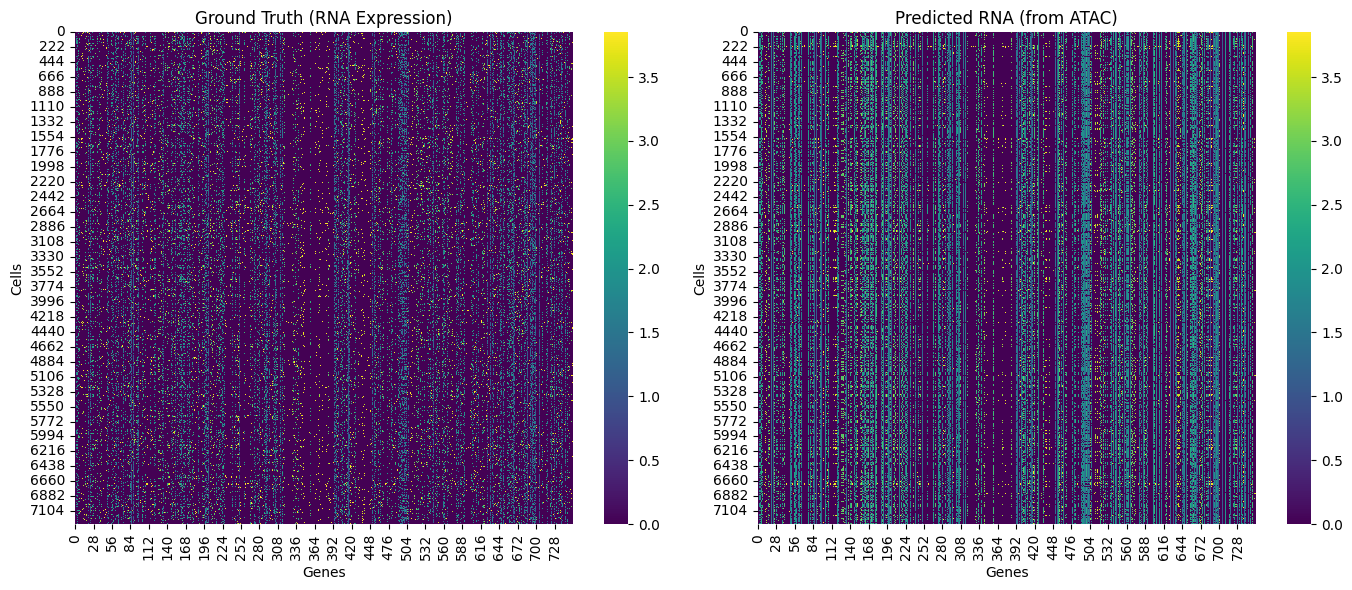

In [13]:
def visualize_rna_prediction_from_atac(model, adata_atac, adata_rna, 
                                       rna_train_offset, # Size of RNA training set (to find ATAC indices)
                                       zero_inflate=1, 
                                       conn_name='conn0', feat_name='feat0'):
    """
    Visualizes RNA (Gene Expression) prediction using ATAC cells as the source.
    """
    print("Generating RNA prediction heatmap (ATAC -> RNA)...")
    
    # --- Move Model and Cache to CPU ---
    model.cpu()
    if 'saved_embeddings' in model.cache:
        for key in model.cache['saved_embeddings']:
            model.cache['saved_embeddings'][key] = model.cache['saved_embeddings'][key].to("cpu")
            
    # 1. Find Intersection (Validation Set)
    # We only visualize cells that exist in both datasets
    valid_cells = adata_atac.obs_names.intersection(adata_rna.obs_names)
    
    if len(valid_cells) == 0:
        print("Error: No overlapping cells found.")
        return

    print(f"Visualizing on {len(valid_cells)} overlapping cells.")

    # 2. Subset Data Objects
    atac_sub = adata_atac[valid_cells].copy() # Source
    rna_sub = adata_rna[valid_cells].copy()   # Target (Ground Truth)
    
    # 3. Get Embeddings for Source (ATAC) cells
    # CRITICAL: ATAC cells are stored AFTER RNA cells in the graph.
    # We must add 'rna_train_offset' to the indices.
    indices = [adata_atac.obs_names.get_loc(c) + rna_train_offset for c in valid_cells]
    
    all_emb = model.cache['saved_embeddings']['cell']
    
    # Safety check
    if max(indices) >= all_emb.shape[0]:
        print(f"Error: Calculated indices exceed embedding size ({all_emb.shape[0]}). Check rna_train_offset.")
        return
        
    source_emb = all_emb[indices]
    
    # 4. Predict RNA (Target)
    # We use the ATAC embeddings to predict the RNA Feature Matrix
    pred_data = pred_from_AnnData(source_emb, rna_sub, zero_inflate, conn_name, feat_name)
    
    pred_data['cell'].x = pred_data['cell'].x.to(torch.float32)
    pred_data = pred_data.to("cpu")
    
    with torch.no_grad():
        preds = predict(model, pred_data)
        
    # 5. Extract Results
    pred_key = f"cell-{conn_name}-{feat_name}"
    
    if zero_inflate == 1:
        raw_output = preds[pred_key]
        if isinstance(raw_output, (tuple, list)):
            vals = raw_output[1].detach().numpy()
            probs = raw_output[0].detach().numpy()
            vals[probs < 0] = 0 
            pred_flat = vals
        else:
            pred_flat = raw_output.detach().numpy()
    else:
        pred_flat = preds[pred_key].detach().numpy()
        
    # Reshape to (N_Cells, N_Genes)
    rna_pred_matrix = pred_flat.reshape(len(valid_cells), rna_sub.n_vars)
    
    # 6. Prepare Ground Truth
    if hasattr(rna_sub.X, "toarray"):
        truth_mat = rna_sub.X.toarray()
    else:
        truth_mat = rna_sub.X

    # 7. Plotting
    # RNA expression can vary widely. We clip at 99th percentile for visibility.
    g_max = np.percentile(truth_mat, 99) 
    if g_max == 0: g_max = 1
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Ground Truth
    sns.heatmap(truth_mat, cmap="viridis", cbar=True, ax=ax[0], vmin=0, vmax=g_max)
    ax[0].set_title("Ground Truth (RNA Expression)")
    ax[0].set_ylabel("Cells")
    ax[0].set_xlabel("Genes")
    
    # Prediction
    sns.heatmap(rna_pred_matrix, cmap="viridis", cbar=True, ax=ax[1], vmin=0, vmax=g_max)
    ax[1].set_title("Predicted RNA (from ATAC)")
    ax[1].set_ylabel("Cells")
    ax[1].set_xlabel("Genes")
    
    plt.tight_layout()
    plt.show()

# --- Execution for RNA Visualization ---
if __name__ == "__main__":
    print("\n--- Visualizing RNA Prediction (ATAC -> RNA) ---")
    
    # We need to know how many RNA cells were in the training graph 
    # to correctly locate the ATAC embeddings.
    n_rna_offset = rna_train.n_obs 
    
    visualize_rna_prediction_from_atac(
        trainer.model,
        atac_train,     # Source (Input)
        rna_train,      # Target (Ground Truth)
        n_rna_offset,   # Offset to find ATAC indices in cache
        zero_inflate=ZERO1, # Use the RNA zero-inflation setting (ZERO1)
        conn_name='conn0',  # Standard edge name for RNA
        feat_name='feat0'   # Standard feature name for RNA
    )